In [1]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from psmpy import PsmPy
import numpy as np
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

In [2]:
#Set up OMOP database connection

config = configparser.ConfigParser()
config.read('omop_db_config_new.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
cursor = sql_conn.cursor(as_dict=True)

In [3]:
#Functions to query db
def get_data(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    df = pd.DataFrame(results, columns=columns)
    return df

def run_query(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    return None

# Motivation 2: Alcohol Addiction as Positive Control

## Defining alc_dependent and not_alc_dependent

In [4]:
#Find all events where alcohol dependence was diagnosed— Includes these conditions
# concept_id	concept_name
# 435243	Alcohol dependence
# 36713086	Alcohol induced disorder co-occurrent and due to alcohol dependence
# 37017563	Severe alcohol dependence
# 37018356	Moderate alcohol dependence
# 45757093	Alcohol dependence in pregnancy

drop_table_query = """DROP TABLE IF EXISTS #alc_dep_population"""

alc_dep_pop_query = """
WITH ConditionFrequency AS (
    SELECT 
        [person_id],
        [condition_concept_id],
        COUNT(*) AS [condition_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
    GROUP BY [person_id], [condition_concept_id]
),
DiagnosisDetails AS (
    SELECT 
        [person_id],
        MIN([condition_start_date]) AS [first_diagnosis_date],
        MAX([condition_start_date]) AS [last_diagnosis_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
    GROUP BY [person_id]
    HAVING COUNT([visit_occurrence_id]) >= 2
),
FirstPatientVisit AS (
    SELECT
        [person_id],
        MIN([visit_start_date]) AS [first_visit]
    FROM [visit_occurrence]
    GROUP BY [person_id]
)
SELECT 
    d.[person_id],
    fpv.[first_visit],
    d.[first_diagnosis_date],
    d.[n_visits],
    cf.[condition_concept_id] AS [most_frequent_condition]
INTO
    #alc_dep_population
FROM 
    DiagnosisDetails d
JOIN 
    ConditionFrequency cf
ON 
    d.[person_id] = cf.[person_id]
JOIN
    FirstPatientVisit fpv
ON
    d.[person_id] = fpv.[person_id]
WHERE 
    cf.rn = 1;
"""

run_query(sql_conn, drop_table_query)
run_query(sql_conn, alc_dep_pop_query)

In [5]:
#Ensure that their records go back at least 6 months before their first diagnosis
query = """
SELECT a.*
FROM #alc_dep_population a
WHERE EXISTS (
    SELECT 1
    FROM observation obs
    WHERE a.person_id = obs.person_id
    AND obs.observation_date <= DATEADD(MONTH, -6, a.first_diagnosis_date)
)
"""

alc_dep_pop = get_data(sql_conn, query)

In [6]:
alc_dep_pop

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition
0,25157,2004-05-29,2012-08-05,7,435243
1,458915,2013-02-22,2017-09-01,17,435243
2,595581,1993-03-12,2021-01-08,4,435243
3,596185,1999-07-20,2023-03-28,3,435243
4,697411,1992-12-28,2002-12-18,4,435243
...,...,...,...,...,...
5473,9488886,2021-02-11,2021-11-12,3,435243
5474,9504219,2015-11-10,2017-10-18,2,435243
5475,9505183,2015-10-07,2017-04-27,5,435243
5476,9647963,2016-02-01,2022-03-30,4,435243


## Create control

In [18]:
#Grabbing a random  20x5438 (# cases) to allow sufficient PSM— THIS CHANGES EACH TIME, NOT DETERMINISTIC

drop_control_table_query = """DROP TABLE IF EXISTS #control_population"""

control_pop_query = """
WITH AlcoholDependencePatients AS (
    SELECT DISTINCT
        [person_id]
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
),
EligibleControls AS (
    SELECT
        [person_id],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [visit_occurrence]
    WHERE [person_id] NOT IN (SELECT [person_id] FROM AlcoholDependencePatients)
    GROUP BY [person_id]
    HAVING COUNT([visit_occurrence_id]) >= 10
),
ControlSample AS (
    SELECT 
        [person_id]
    FROM EligibleControls
    ORDER BY NEWID() -- Randomly select controls
    OFFSET 0 ROWS
    FETCH NEXT (5478 * 20) ROWS ONLY
),
ControlDetails AS (
    SELECT 
        ecs.[person_id],
        MIN(vo.[visit_start_date]) AS [first_patient_visit],
        MAX(vo.[visit_start_date]) AS [last_visit_date],
        COUNT(vo.[visit_occurrence_id]) AS [n_visits]
    FROM 
        ControlSample ecs
    JOIN 
        [visit_occurrence] vo
    ON 
        ecs.[person_id] = vo.[person_id]
    GROUP BY 
        ecs.[person_id]
),
ControlWithSixMonths AS (
    SELECT
        cd.[person_id],
        cd.[first_patient_visit],
        cd.[n_visits]
    FROM 
        ControlDetails cd
    WHERE EXISTS (
        SELECT 1
        FROM [visit_occurrence] vo
        WHERE cd.[person_id] = vo.[person_id]
        AND vo.[visit_start_date] >= DATEADD(MONTH, 6, cd.[first_patient_visit])
    )
)
SELECT
    cwsm.[person_id],
    cwsm.[first_patient_visit] AS first_visit,
    cwsm.[n_visits]
FROM
    ControlWithSixMonths cwsm;
"""

run_query(sql_conn, drop_control_table_query)

alc_control_pop = get_data(sql_conn, control_pop_query)



In [40]:
alc_dep_pop

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition
0,129020,1999-02-28,1999-11-08,3,435243
1,592160,2001-01-16,2002-01-21,2,435243
2,741611,2006-06-13,2016-08-23,2,435243
3,894148,2017-11-14,2022-01-29,4,435243
4,901930,2010-12-28,2015-06-19,2,435243
...,...,...,...,...,...
5473,9589068,2015-04-01,2017-11-24,9,435243
5474,9670287,2015-11-03,2022-12-06,4,435243
5475,9957445,2023-03-13,2023-07-28,2,435243
5476,10244270,2000-08-04,2016-05-12,5,435243


In [19]:
alc_control_pop

,person_id,first_visit,n_visits
0,5274,1989-06-20,31
1,6537,1991-04-30,24
2,7916,1970-12-17,2135
3,32409,1996-11-03,18
4,35013,2002-07-09,32
...,...,...,...
99282,10381618,2023-02-06,30
99283,10421619,2023-06-10,60
99284,10477439,2018-12-13,61
99285,10482269,2007-06-02,47


# Add Age, Sex Data for PSM

In [7]:
# Create Table with alcohol dependence patient IDs
alc_dep_ids = alc_dep_pop['person_id'].to_list()
alc_dep_ids = '), ('.join([str(subject_id) for subject_id in alc_dep_ids])
alc_dep_ids = '(' + alc_dep_ids + ')'
alc_dep_ids = alc_dep_ids.split(', ')

query_alc_dep_ids = f"""
DROP TABLE IF EXISTS #alc_dep_patient_ids;
CREATE TABLE #alc_dep_patient_ids (person_id INT);
"""

for subject_id in alc_dep_ids:
    query_alc_dep_ids += f"""
    INSERT INTO #alc_dep_patient_ids (person_id)
    VALUES {subject_id};
    """

run_query(sql_conn, query_alc_dep_ids)


# Add age and sex info to alcohol dependence table
alc_dep_bio_query = """
SELECT
    p.person_id, 
    p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value
FROM
    #alc_dep_patient_ids ad
    JOIN [person] p
        ON ad.person_id = p.person_id
"""

alc_dep_pop = alc_dep_pop.merge(get_data(sql_conn, alc_dep_bio_query), on='person_id', how='left')


# Create Table with control population patient IDs
control_ids = alc_control_pop['person_id'].to_list()
control_ids = '), ('.join([str(subject_id) for subject_id in control_ids])
control_ids = '(' + control_ids + ')'
control_ids = control_ids.split(', ')

query_control_ids = f"""
DROP TABLE IF EXISTS #control_patient_ids;
CREATE TABLE #control_patient_ids (person_id INT);
"""

for subject_id in control_ids:
    query_control_ids += f"""
    INSERT INTO #control_patient_ids (person_id)
    VALUES {subject_id};
    """

run_query(sql_conn, query_control_ids)

# Add age and sex info to control table
control_bio_query = """
SELECT
    p.person_id, 
    p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value
FROM
    #control_patient_ids cp
    JOIN [person] p
        ON cp.person_id = p.person_id
"""

alc_control_pop = alc_control_pop.merge(get_data(sql_conn, control_bio_query), on='person_id', how='left')

NameError: name 'alc_control_pop' is not defined

In [10]:
alc_dep_pop

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition,gender_source_value,age,ethnicity_source_value
0,25157,2004-05-29,2012-08-05,7,435243,Female,73,Not Hispanic or Latino
1,458915,2013-02-22,2017-09-01,17,435243,Male,43,Not Hispanic or Latino
2,595581,1993-03-12,2021-01-08,4,435243,Female,58,Not Hispanic or Latino
3,596185,1999-07-20,2023-03-28,3,435243,Female,34,Not Hispanic or Latino
4,697411,1992-12-28,2002-12-18,4,435243,Male,78,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...
5473,9488886,2021-02-11,2021-11-12,3,435243,Male,61,Not Hispanic or Latino
5474,9504219,2015-11-10,2017-10-18,2,435243,Female,57,Not Hispanic or Latino
5475,9505183,2015-10-07,2017-04-27,5,435243,Male,61,Not Hispanic or Latino
5476,9647963,2016-02-01,2022-03-30,4,435243,Female,50,Not Hispanic or Latino


In [43]:
alc_control_pop

,person_id,first_visit,n_visits,gender_source_value,age,ethnicity_source_value
0,2568,2006-01-09,16,Female,34,*Unspecified
1,4363,2000-03-25,59,Female,51,Not Hispanic or Latino
2,12421,2018-08-19,11,Male,6,Unknown
3,13387,2006-11-17,29,Male,34,Hispanic or Latino
4,15863,2005-06-08,19,Female,91,Not Hispanic or Latino
...,...,...,...,...,...,...
99245,10368819,2019-08-26,10,Female,81,Declined
99246,10395798,2023-08-04,25,Female,24,Declined
99247,10432159,2021-05-02,15,Female,16,Declined
99248,10450373,2021-05-04,22,Female,3,Declined


In [28]:
alc_dep_pop.to_feather('data/alc_addicted.feather')
alc_control_pop.to_feather('data/not_alc_addicted.feather')

# Perform PSM on Age, Sex, ethnicity_source_value

In [ ]:
# Add a 'dependent' column to identify alcohol dependence cases
alc_dep_pop['dependent'] = 1
alc_control_pop['dependent'] = 0

# Concatenate alcohol dependence and control populations into a single DataFrame
full_bio_cohort = pd.concat([alc_dep_pop, alc_control_pop], axis=0, ignore_index=True)

# Convert gender to numerical values
full_bio_cohort['gender_source_value'] = full_bio_cohort['gender_source_value'].map({'Male': 0, 'Female': 1}).fillna(2).astype(int)

# Convert gender to numerical values
full_bio_cohort['gender_source_value'] = full_bio_cohort['gender_source_value'].map({'Male': 0, 'Female': 1}).fillna(2).astype(int)

#Convert ethnicity to numerical values
full_bio_cohort['ethnicity_source_value'] = pd.factorize(full_bio_cohort['ethnicity_source_value'])[0]

# Create an instance of PsmPy with the relevant columns
prop_sm = PsmPy(full_bio_cohort[['person_id', 'gender_source_value', 'age', 'dependent', 'ethnicity_source_value']], treatment='dependent', indx='person_id')

# Calculate the propensity scores based on sex, age, and other relevant variables
prop_sm.logistic_ps(balance=True)

# Perform matching, with a ratio of 8 controls to each dependent subject
prop_sm.knn_matched_12n(matcher='propensity_logit', how_many=4)

# List of final ids for cohort, after matching
final_cohort_ids = prop_sm.matched_ids.values.ravel()

In [ ]:
prop_sm.matched_ids

In [ ]:
prop_sm.effect_size_plot(save=True)

In [ ]:
#save the ids list so don't need to re-run PSM
prop_sm.matched_ids.to_feather("data/alcohol_cohort_ids.feather")

# Create Metatables for each ID after PSM

In [ ]:
# #Recreate alc_dep_pop because it is not deterministically made, can't rerun old code (using the ids from psm output)


# query_recreate_control = f"""
# DROP TABLE IF EXISTS #alc_control_pop_ids;
# CREATE TABLE #alc_control_pop_ids (person_id INT);
# """

# for id in final_cohort_ids:
#     query_recreate_control += f"""
# INSERT INTO #alc_control_pop_ids (person_id)
# VALUES ({id});
# """

# run_query(sql_conn, query_recreate_control)

# q_recreate = """
# WITH AlcoholDependencePatients AS (
#     SELECT DISTINCT
#         [person_id]
#     FROM [condition_occurrence]
#     WHERE [condition_concept_id] IN 
#         (SELECT [concept_id]
#          FROM [concept]
#          WHERE [concept_name] LIKE '%alcohol dependence%'
#          AND [domain_id] = 'Condition')
# ),
# EligibleControls AS (
#     SELECT
#         [person_id],
#         COUNT([visit_occurrence_id]) AS [n_visits]
#     FROM [visit_occurrence]
#     WHERE [person_id] NOT IN (SELECT [person_id] FROM AlcoholDependencePatients)
#     GROUP BY [person_id]
#     HAVING COUNT([visit_occurrence_id]) >= 10
# ),
# ControlSample AS (
#     SELECT 
#         [person_id]
#     FROM 
#         EligibleControls
#     WHERE 
#         [person_id] IN (SELECT [person_id] FROM #alc_control_pop_ids)
# ),
# ControlDetails AS (
#     SELECT 
#         ecs.[person_id],
#         MIN(vo.[visit_start_date]) AS [first_patient_visit],
#         MAX(vo.[visit_start_date]) AS [last_visit_date],
#         COUNT(vo.[visit_occurrence_id]) AS [n_visits]
#     FROM 
#         ControlSample ecs
#     JOIN 
#         [visit_occurrence] vo
#     ON 
#         ecs.[person_id] = vo.[person_id]
#     GROUP BY 
#         ecs.[person_id]
# ),
# ControlWithSixMonths AS (
#     SELECT
#         cd.[person_id],
#         cd.[first_patient_visit],
#         cd.[n_visits]
#     FROM 
#         ControlDetails cd
#     WHERE EXISTS (
#         SELECT 1
#         FROM [visit_occurrence] vo
#         WHERE cd.[person_id] = vo.[person_id]
#         AND vo.[visit_start_date] >= DATEADD(MONTH, 6, cd.[first_patient_visit])
#     )
# )
# SELECT
#     cwsm.[person_id],
#     cwsm.[first_patient_visit] AS first_visit,
#     cwsm.[n_visits]
# FROM
#     ControlWithSixMonths cwsm;
# """

# alc_dep_pop = get_data(sql_conn, q_recreate)

# # Create Table with control population patient IDs
# control_ids = alc_control_pop['person_id'].to_list()
# control_ids = '), ('.join([str(subject_id) for subject_id in control_ids])
# control_ids = '(' + control_ids + ')'
# control_ids = control_ids.split(', ')

# query_control_ids = f"""
# DROP TABLE IF EXISTS #control_patient_ids;
# CREATE TABLE #control_patient_ids (person_id INT);
# """

# for subject_id in control_ids:
#     query_control_ids += f"""
#     INSERT INTO #control_patient_ids (person_id)
#     VALUES {subject_id};
#     """

# run_query(sql_conn, query_control_ids)

# # Add age and sex info to control table
# control_bio_query = """
# SELECT
#     p.person_id, 
#     p.gender_source_value, 
#     2024 - p.year_of_birth AS age, 
#     p.ethnicity_source_value
# FROM
#     #control_patient_ids cp
#     JOIN [person] p
#         ON cp.person_id = p.person_id
# """

# alc_control_pop = alc_control_pop.merge(get_data(sql_conn, control_bio_query), on='person_id', how='left')
#alc_control_pop.to_feather('data/not_alc_addicted.feather')

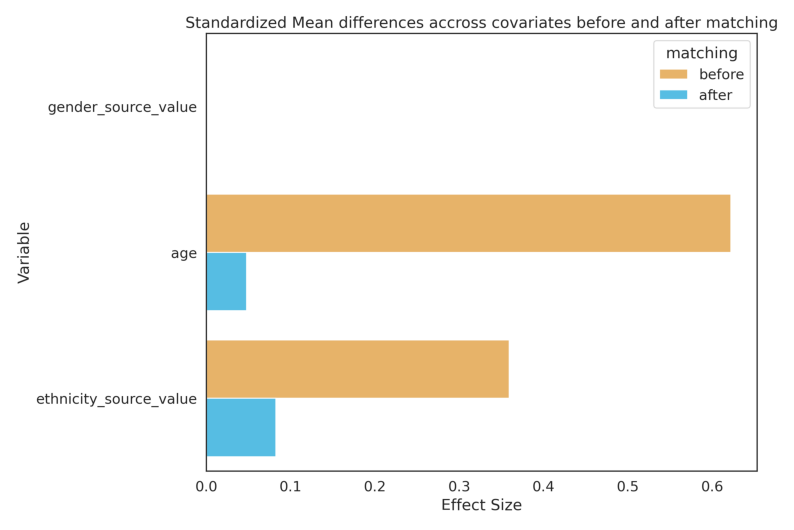

In [115]:
alc_addicted = pd.read_feather("data/alc_addicted.feather")
not_alc_addicted = pd.read_feather("data/not_alc_addicted.feather")
psm_ids = pd.read_feather("data/alcohol_cohort_ids.feather")
final_cohort_ids = psm_ids.values.ravel()
img = mpimg.imread('effect_size.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [117]:
alc_addicted

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition,gender_source_value,age,ethnicity_source_value
0,25157,2004-05-29,2012-08-05,7,435243,Female,73,Not Hispanic or Latino
1,458915,2013-02-22,2017-09-01,17,435243,Male,43,Not Hispanic or Latino
2,595581,1993-03-12,2021-01-08,4,435243,Female,58,Not Hispanic or Latino
3,596185,1999-07-20,2023-03-28,3,435243,Female,34,Not Hispanic or Latino
4,697411,1992-12-28,2002-12-18,4,435243,Male,78,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...
5473,9488886,2021-02-11,2021-11-12,3,435243,Male,61,Not Hispanic or Latino
5474,9504219,2015-11-10,2017-10-18,2,435243,Female,57,Not Hispanic or Latino
5475,9505183,2015-10-07,2017-04-27,5,435243,Male,61,Not Hispanic or Latino
5476,9647963,2016-02-01,2022-03-30,4,435243,Female,50,Not Hispanic or Latino


In [116]:
not_alc_addicted

,person_id,first_visit,n_visits,gender_source_value,age,ethnicity_source_value
0,21595,2013-05-14,17,Female,21,Not Hispanic or Latino
1,21902,2001-08-20,16,Female,65,Not Hispanic or Latino
2,31019,1999-10-05,86,Male,68,Not Hispanic or Latino
3,34899,2013-12-24,149,Female,65,Not Hispanic or Latino
4,51518,1994-10-04,16,Male,72,Not Hispanic or Latino
...,...,...,...,...,...,...
21907,9690396,2021-04-19,13,Female,74,Not Hispanic or Latino
21908,9696461,2022-03-26,105,Female,54,Not Hispanic or Latino
21909,10175609,2023-05-18,250,Female,73,Not Hispanic or Latino
21910,10258120,2022-09-26,43,Female,72,Not Hispanic or Latino


In [118]:
#Change not_op and full_bio_cohort to reflect the PSM matching
not_alc_addicted = not_alc_addicted[not_alc_addicted['person_id'].isin(final_cohort_ids)]

full_bio_cohort = pd.concat([alc_addicted, not_alc_addicted], axis=0, ignore_index=True)

In [119]:
full_bio_cohort

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition,gender_source_value,age,ethnicity_source_value
0,25157,2004-05-29,2012-08-05,7,435243.0,Female,73,Not Hispanic or Latino
1,458915,2013-02-22,2017-09-01,17,435243.0,Male,43,Not Hispanic or Latino
2,595581,1993-03-12,2021-01-08,4,435243.0,Female,58,Not Hispanic or Latino
3,596185,1999-07-20,2023-03-28,3,435243.0,Female,34,Not Hispanic or Latino
4,697411,1992-12-28,2002-12-18,4,435243.0,Male,78,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...
27385,9690396,2021-04-19,NaN,13,NaN,Female,74,Not Hispanic or Latino
27386,9696461,2022-03-26,NaN,105,NaN,Female,54,Not Hispanic or Latino
27387,10175609,2023-05-18,NaN,250,NaN,Female,73,Not Hispanic or Latino
27388,10258120,2022-09-26,NaN,43,NaN,Female,72,Not Hispanic or Latino


In [120]:
# Create a SQL table with the full cohort ids. This will be used to find relevant concepts and encode them for SPOKE
query_EHR_concept_ref = f"""
DROP TABLE IF EXISTS #ehr_concept_ref;
CREATE TABLE #ehr_concept_ref (person_id INT);
"""

for index, row in full_bio_cohort.iterrows():
    query_EHR_concept_ref += f"""
INSERT INTO #ehr_concept_ref (person_id)
VALUES ({row['person_id']});
"""

run_query(sql_conn, query_EHR_concept_ref)

In [121]:
#Creating concept metatables for drug and conditions (labs are harder, done below)— did not choose to include person qualities

query_drugs_mt = """
SELECT d.[person_id]
    ,[drug_concept_id] AS concept
FROM [drug_exposure] d
JOIN #ehr_concept_ref ref ON d.person_id = ref.person_id
"""
drugs_mt = get_data(sql_conn, query_drugs_mt).drop_duplicates()

query_conditions_mt = """
SELECT c.[person_id]
    ,[condition_concept_id] AS concept
FROM [condition_occurrence] c
JOIN #ehr_concept_ref ref ON c.person_id = ref.person_id
"""
conditions_mt = get_data(sql_conn, query_conditions_mt).drop_duplicates()

## Getting Lab Tests

In [123]:
#First get the person_source_values, this is the key to mapping OMOP to CDW
person_source_values_query = """
SELECT ehr.person_id, p.person_source_value
FROM #ehr_concept_ref AS ehr
JOIN person AS p ON ehr.person_id = p.person_id;
"""
omop_spoke_sourcevalues = get_data(sql_conn, person_source_values_query)

In [124]:
#Set up CDW database connection
config = configparser.ConfigParser()
config.read('cdw_db_config.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

cdw_sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
sql_cursor = cdw_sql_conn.cursor(as_dict=True)


In [125]:
#Recreate the OMOP->CDW table in the CDW SQL driver
query_person_sv = f"""
DROP TABLE IF EXISTS #person_source_values;
CREATE TABLE #person_source_values (person_id INT, person_source_value VARCHAR(20));
"""

for index, row in omop_spoke_sourcevalues.iterrows():
    query_person_sv += f"""
INSERT INTO #person_source_values (person_id, person_source_value)
VALUES ({row['person_id']}, '{row['person_source_value']}');
"""
    
run_query(cdw_sql_conn, query_person_sv)

In [126]:
#Create a table of LOINC IDs each id got prescribed
abnormal_lab_query = """
WITH PersonToDurableKey AS (
    SELECT ps.person_id, pdd.PatientDurableKey
    FROM [CDW_NEW].[deid_uf].[PatDurableDim] AS pdd
    JOIN #person_source_values AS ps ON ps.person_source_value = pdd.PatientEpicId
)

SELECT pd.person_id, lcrf.ComponentLoincCode AS concept
    FROM PersonToDurableKey AS pd
    JOIN [CDW_NEW].[deid_uf].LabComponentResultFact AS lcrf ON pd.PatientDurableKey = lcrf.PatientDurableKey
    WHERE lcrf.Abnormal = 1
"""

labs_mt = get_data(cdw_sql_conn, abnormal_lab_query).drop_duplicates()

In [127]:
#Recreate the LOINC table in the OMOP SQL driver to map to OMOP concepts
query_loinc_codes = f"""
DROP TABLE IF EXISTS #loinc_ids;
CREATE TABLE #loinc_ids (person_id INT, loinc_id VARCHAR(20));
"""

for index, row in labs_mt.iterrows():
    query_loinc_codes += f"""
INSERT INTO #loinc_ids (person_id, loinc_id)
VALUES ({row['person_id']}, '{row['concept']}');
"""
    
run_query(sql_conn, query_loinc_codes)

In [128]:
#Get the OMOP concepts from the LOINC IDs
query_loinc_to_omop = f"""
SELECT l.person_id, c.concept_id AS concept
FROM #loinc_ids AS l
INNER JOIN concept AS c ON l.loinc_id = c.concept_code;
"""

labs_mt = get_data(sql_conn, query_loinc_to_omop)

In [129]:
labs_mt

,person_id,concept
0,26227,3026770
1,8660885,3027597
2,9415261,3027597
3,9143298,3027597
4,9303285,3027597
...,...,...
357960,8524287,3041473
357961,4656144,3041473
357962,9277907,3041473
357963,9521497,3041473


# Translate Concepts to SPOKE Codes, Formatting for SEPs

In [130]:
#Translating conditions
# disease_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_conditions_to_spoke_extended_2.tsv', sep = '\t')

disease_annotation = pd.read_csv('../../gbellucci/spoke_linkers/omop2spoke_combined.tsv', sep = '\t')
disease_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
disease_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(disease_annotation['condition_concept_id'], disease_annotation['spoke_concept_id']))

conditions_mt['spoke_code'] = conditions_mt['concept'].map(omop_to_spoke_dict)

#Translating Drugs
drug_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_drug_exposure_to_spoke_extended.tsv', sep = '\t')
drug_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
drug_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(drug_annotation['condition_concept_id'], drug_annotation['spoke_concept_id']))

drugs_mt['spoke_code'] = drugs_mt['concept'].map(omop_to_spoke_dict)

#Translating measurements
lab_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_measurement_to_spoke_extended.tsv', sep = '\t')
lab_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
lab_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(lab_annotation['condition_concept_id'], lab_annotation['spoke_concept_id']))

labs_mt['spoke_code'] = labs_mt['concept'].map(omop_to_spoke_dict)

In [133]:
#Can see which codes were not matched to a SPOKE node; just switch out meta table

def dropped_stats(table_name):
    # fraction of unique concepts missed in mapping
    f_missed = table_name[table_name['spoke_code'].isna()]['concept'].nunique() / table_name['concept'].nunique()

    #Number of unique concepts mapped
    unique_mapped = table_name['concept'].nunique() - table_name[table_name['spoke_code'].isna()]['concept'].nunique()

    #Number of unique concepts total
    unique_concepts = table_name['concept'].nunique()

    #Total fraction of concepts missed in mapping
    total_missed = len(table_name[table_name['spoke_code'].isna()]['concept']) / len(table_name['concept'])

    print(f"Fraction of unique concepts missed: {f_missed} \n Number of unique concepts mapped: {unique_mapped} \n Number of unique concepts: {unique_concepts} \n Total missed: {total_missed}")

dropped_stats(conditions_mt)

Fraction of unique concepts missed: 0.9373930056248472 
 Number of unique concepts mapped: 1536 
 Number of unique concepts: 24534 
 Total missed: 0.8417919031587225


In [134]:
#One hot encode all the concepts

#Drop anything that wasn't mapped to SPOKE
concepts_ehr = pd.concat([drugs_mt, conditions_mt, labs_mt], ignore_index=True)
concepts_ehr = concepts_ehr[concepts_ehr['spoke_code'].notna()]

#Drop repeat spoke codes (multiple OMOP map to single SPOKE)
concepts_ehr = concepts_ehr[['person_id', 'spoke_code']].drop_duplicates()

# Create dummy variables
dummies = pd.get_dummies(concepts_ehr['spoke_code'])

# Concatenate with the original DataFrame to have IDs
df_with_dummies = pd.concat([concepts_ehr[['person_id']], dummies], axis=1)

# Group by 'person_id' and sum up the dummy columns to avoid multiple rows for the same person
#doing this in chunks since takes too much memory to use groupby directly
chunk_size = 10000
results = []

# Process the DataFrame in chunks
num_chunks = (len(df_with_dummies) // chunk_size) + 1  # Calculate total number of chunks
for start in tqdm(range(0, len(df_with_dummies), chunk_size)):
    chunk = df_with_dummies.iloc[start:start + chunk_size]
    
    # Perform the groupby and aggregation for the current chunk
    chunk_result = chunk.groupby('person_id').sum().reset_index()
    
    # Append the chunk result to the results list
    results.append(chunk_result)
    
# Concatenate all chunk results into a final DataFrame
final_df = pd.concat(results, ignore_index=True)

# Final aggregation to ensure no duplicates (in case of overlapping person_ids across chunks)
final_df = final_df.groupby('person_id').sum().reset_index()

100%|██████████| 57/57 [00:18<00:00,  3.03it/s]


In [135]:
# Makes sure that one-hot encoding works, should not be >1 for any cell (except for person_id column) — Should be False
(final_df.iloc[:, 1:] > 1).any().any()

np.False_

In [136]:
final_df.to_feather("data/alc_concept_map.feather")
full_bio_cohort.to_feather('data/alc_cohort_details.feather')

In [137]:
final_df

,person_id,C0032961,C0041296,C0151632,CHEMBL112570,CHEMBL1200830,CHEMBL1222250,CHEMBL1618018,CHEMBL2146121,CHEMBL2219425,...,UBERON:0001088,UBERON:0001089,UBERON:0001135,UBERON:0001264,UBERON:0001690,UBERON:0001968,UBERON:0001969,UBERON:0001970,UBERON:0001988,UBERON:0002113
0,1242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2615,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3423,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4681,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5806,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24946,10497163,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24947,10502015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24948,10508290,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24949,10530139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
full_bio_cohort

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition,gender_source_value,age,ethnicity_source_value
0,25157,2004-05-29,2012-08-05,7,435243.0,Female,73,Not Hispanic or Latino
1,458915,2013-02-22,2017-09-01,17,435243.0,Male,43,Not Hispanic or Latino
2,595581,1993-03-12,2021-01-08,4,435243.0,Female,58,Not Hispanic or Latino
3,596185,1999-07-20,2023-03-28,3,435243.0,Female,34,Not Hispanic or Latino
4,697411,1992-12-28,2002-12-18,4,435243.0,Male,78,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...
27385,9690396,2021-04-19,NaN,13,NaN,Female,74,Not Hispanic or Latino
27386,9696461,2022-03-26,NaN,105,NaN,Female,54,Not Hispanic or Latino
27387,10175609,2023-05-18,NaN,250,NaN,Female,73,Not Hispanic or Latino
27388,10258120,2022-09-26,NaN,43,NaN,Female,72,Not Hispanic or Latino


In [139]:
full_bio_cohort[~full_bio_cohort['person_id'].isin(final_df['person_id'])]

,person_id,first_visit,first_diagnosis_date,n_visits,most_frequent_condition,gender_source_value,age,ethnicity_source_value
5478,21595,2013-05-14,NaN,17,NaN,Female,21,Not Hispanic or Latino
5488,183078,2006-10-30,NaN,15,NaN,Male,76,Hispanic or Latino
5499,424308,2008-10-19,NaN,23,NaN,Male,46,Not Hispanic or Latino
5500,437140,1993-04-09,NaN,14,NaN,Female,90,Not Hispanic or Latino
5508,659541,1992-01-07,NaN,10,NaN,Male,91,Unknown/Declined
...,...,...,...,...,...,...,...,...
27296,9101701,2020-10-16,NaN,10,NaN,Female,70,Not Hispanic or Latino
27310,9156468,2000-09-03,NaN,15,NaN,Female,59,Not Hispanic or Latino
27321,9220022,2022-03-10,NaN,67,NaN,Female,45,Not Hispanic or Latino
27354,9433141,2016-12-02,NaN,30,NaN,Female,59,Not Hispanic or Latino
